### Ссылка github с актуальной версией

Путь: 4/LinearRegression/

https://github.com/Oblivalny/iit_ml

In [1059]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import scipy

In [1060]:
df = pd.read_csv("data.csv")

In [1061]:
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [1062]:
del df['Id']

In [1063]:
# df.describe()

Разделим данные на количественные и категориальные. Это понадобится нам для дальнейшей раздельной предобработки.

In [1064]:
# df.info()

In [1065]:
dtype = pd.DataFrame({"columns":df.dtypes.index,
                     "dtype":df.dtypes})
dtype["dtype"] = [str(i) for i in dtype["dtype"]]
dtype.head(2)

,columns,dtype
MSSubClass,MSSubClass,int64
MSZoning,MSZoning,object


In [1066]:
num_columns = dtype.query('dtype=="int64" | dtype=="float64"')["columns"].values[1:-1]
obj_columns = dtype.query('dtype=="object"')["columns"].values

print("numerical_values_count:{}".format(len(num_columns)))
print("object_values_count:{}".format(len(obj_columns)))

numerical_values_count:35
object_values_count:43


# EDA & Data preprocessing

Проведите упращенный анализ данных.

In [1067]:
df[obj_columns].head(2)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### Категориальные признаки

### Null data

Проведите анализ данных по нулевым значениям. Решите, что вы будете делать с этими данными (удалить, заполнить нулями или средним или как-то иначе) 

#### Работаем с пустыми значениями

In [1068]:
columns_with_null = df[obj_columns].isna().any()
columns_with_null = columns_with_null[columns_with_null==True]
pr_null = [] 
for col in columns_with_null.index:
    pr_null.append(round(df[df[col].isnull()].shape[0]/df[col].shape[0]*100,2))

df_null_val = pd.DataFrame({'Columns_with_null':columns_with_null.index, 'Percent_null_val':pr_null })
df_null_val

,Columns_with_null,Percent_null_val
0,Alley,93.77
1,MasVnrType,0.55
2,BsmtQual,2.53
3,BsmtCond,2.53
4,BsmtExposure,2.60
5,BsmtFinType1,2.53
6,BsmtFinType2,2.60
7,Electrical,0.07
8,FireplaceQu,47.26
9,GarageType,5.55


#### У признаков Alley, PoolQC, Fence, MiscFeature слишком много мустых значений.

##### У следующих признаков есть информация в документации о отсутствии значания NA, поэтому все пустые значения можно заменить на NA
###### Alley -             Тип подъезда к аллее
###### PoolQC -            качество бассейна
###### Fence -             Забор: качество забора
###### FireplaceQu - качество камина.

##### У этого признака нет информация в документации о отсутствии значания NA, поэтому лучше всего избавится от этого признака. 
###### MiscFeature -       прочие функции, не относящиеся к другим категориям

In [1069]:
df = df.drop(columns=['MiscFeature'])

In [1070]:
for col in ['Alley', 'PoolQC', 'Fence', 'FireplaceQu']:
    df[col].fillna('NA', inplace=True)

#### Для того чтобы убрать пустые значения нужно посмотреть на значения признаков.

#### Есть значение NA в документации
###### BsmtQual          Высота подвала
###### BsmtCond          Общее состояние подвала.
###### BsmtExposure      Подвальные стены на уровне сада или выхода
###### BsmtFinType1      Качество готовой площади подвала
###### BsmtFinType2      Качество второй законченной области (если есть)
###### FireplaceQu       качество камина
###### GarageType        расположение гаража
###### GarageFinish      Внутренняя отделка гаража.
###### GarageQual        качество гаража
###### GarageCond        Состояние гаража

In [1071]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'FireplaceQu' , 'GarageType', 'GarageFinish' , 'GarageQual', 'GarageCond']:
    df[col].fillna('NA', inplace=True)

#### НЕТ значение NA в документации

#### Можно заменить самым часто встречаемым значением. Так можно сделать из-за того, что этот признак присущь каждому дому и скорее всего не может быть null. 
###### MasVnrType        Тип облицовки кладки
###### Electrical        электрическая система

In [1072]:
df.MasVnrType.fillna(df.MasVnrType.mode(), inplace=True)

In [1073]:
df.Electrical.fillna(df.Electrical.mode(), inplace=True)

#### Посмотрим на распределение значений категориальных признаков. 

In [1074]:
dtype = pd.DataFrame({"columns":df.dtypes.index,
                     "dtype":df.dtypes})
dtype["dtype"] = [str(i) for i in dtype["dtype"]]

num_columns = dtype.query('dtype=="int64" | dtype=="float64"')["columns"].values[1:-1]
obj_columns = dtype.query('dtype=="object"')["columns"].values

print("numerical_values_count:{}".format(len(num_columns)))
print("object_values_count:{}".format(len(obj_columns)))

numerical_values_count:35
object_values_count:42


In [1089]:
import matplotlib.pyplot as plt
def example_plot(ax, val, lable, type_plot='bar'):
    
    if type_plot=='bar':
        val = round(val.value_counts()/val.shape[0]*100)
        ax.bar(val.index, val.values, label=lable)
        
    elif type_plot=='hist':
        ax.hist(val, 50, density=True, facecolor='g', alpha=0.75)
        ax.set_ylabel('pr', fontsize=9)
    ax.set_title(lable, fontsize=14)

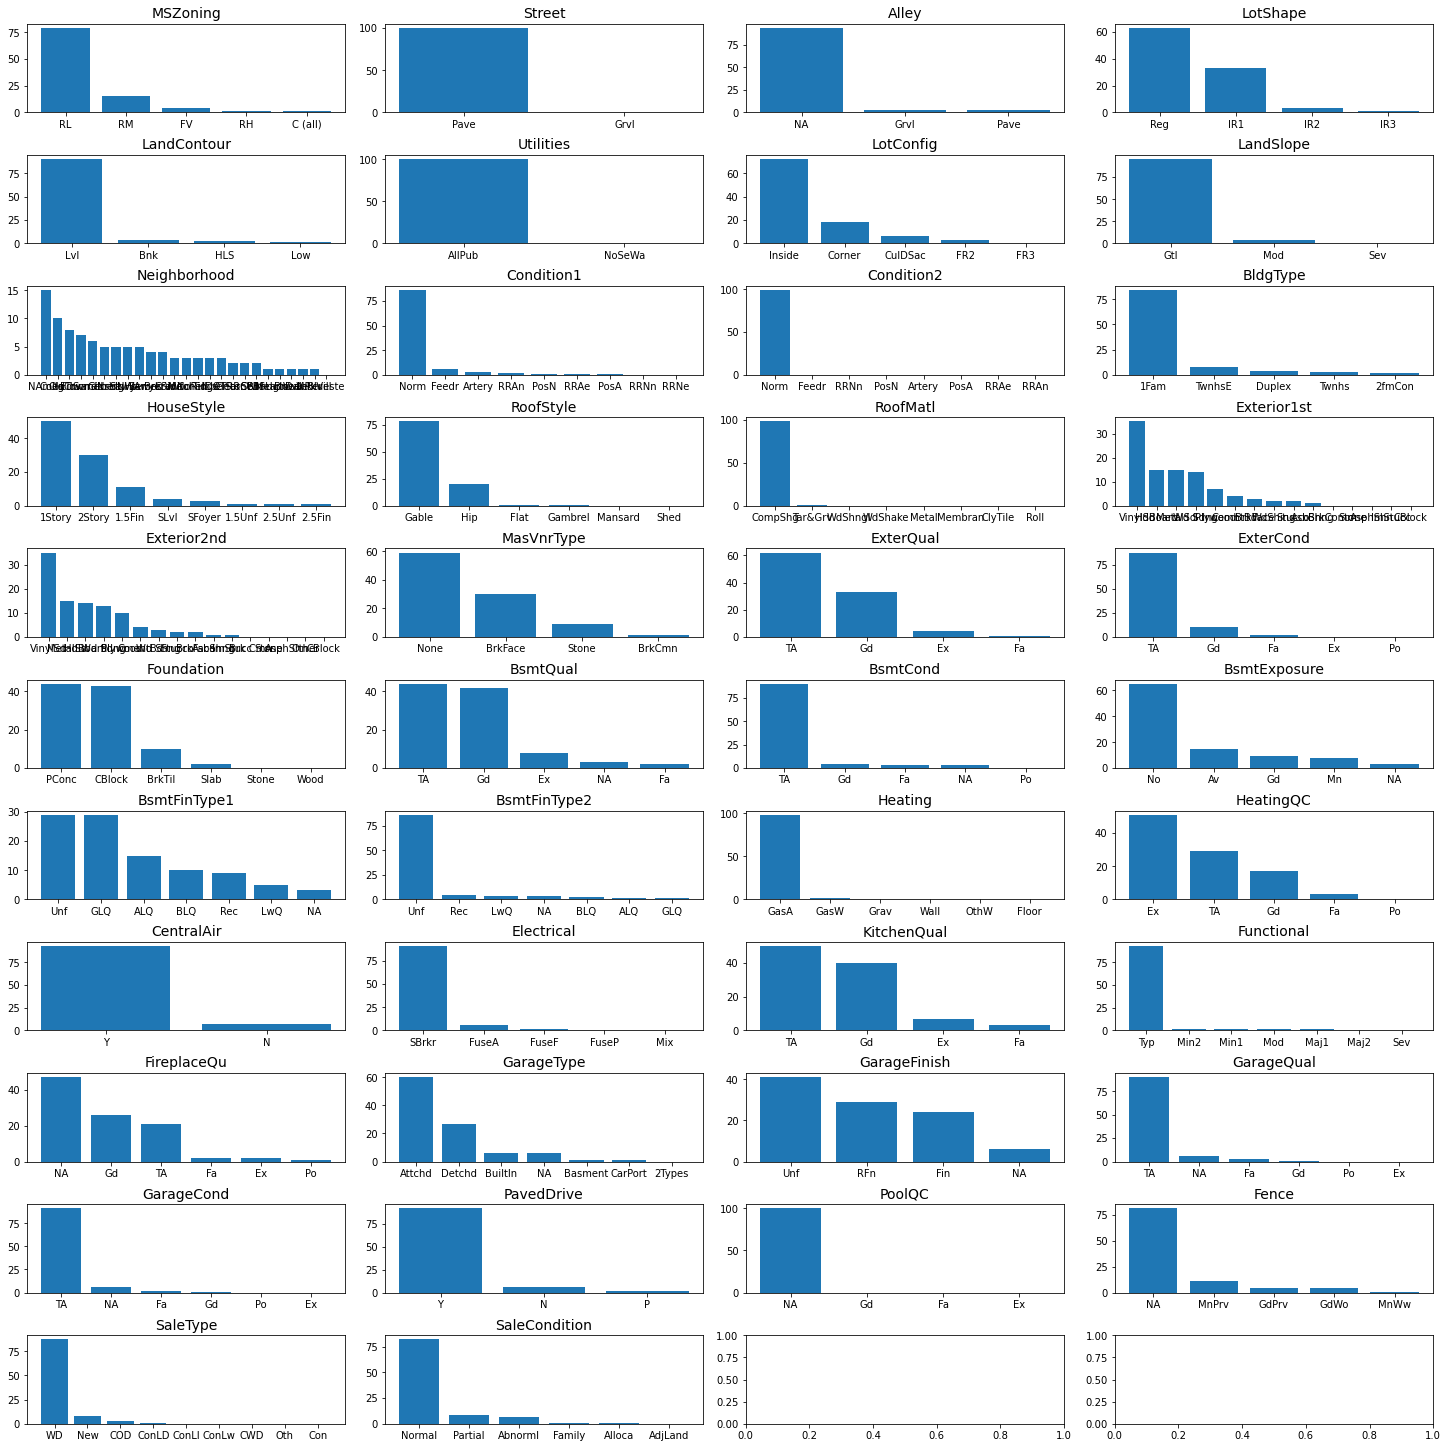

In [68]:
fig, axs = plt.subplots(nrows=11, ncols=4, constrained_layout=True, figsize=(20, 20))

for i in range(obj_columns.shape[0]):
    example_plot(axs.flat[i], df[obj_columns[i]], obj_columns[i])

#### Есть категориальные признаки в которых сильно приобладает одно значение. По факту эти признаки не привносят дополнительной информации и от них можно избавится, а можно и не исбавлятся так, как модель скорее всего занулит их вес

##   

### Числовые признаки 

### Null data

Проведите анализ данных по нулевым значениям. Решите, что вы будете делать с этими данными (удалить, заполнить нулями или средним или как-то иначе) 

#### Работаем с пустыми значениями

In [1076]:
columns_with_null = df[num_columns].isna().any()
columns_with_null = columns_with_null[columns_with_null==True]
pr_null = [] 
for col in columns_with_null.index:
    pr_null.append(round(df[df[col].isnull()].shape[0]/df[col].shape[0]*100,2))

df_null_val = pd.DataFrame({'Columns_with_null':columns_with_null.index, 'Percent_null_val':pr_null })
df_null_val

,Columns_with_null,Percent_null_val
0,LotFrontage,17.74
1,MasVnrArea,0.55
2,GarageYrBlt,5.55


In [983]:
#### LotFrontage: Линейные ноги улицы, соединенной с участком (????????)
#### MasVnrArea: Площадь облицовки кладки в квадратных футах
#### GarageYrBlt: Year garage was built

C:\Users\rfrep\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\rfrep\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


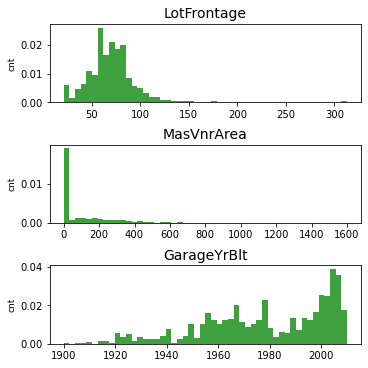

In [1077]:
fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True, figsize=(5, 5))
for i in range(df_null_val.shape[0]):
    example_plot(axs.flat[i], df[df_null_val.Columns_with_null.iloc[i]], df_null_val.Columns_with_null.iloc[i], 'hist')

#### Заменяем Null на медианы так, как распределения признаков не нормальное

In [1080]:
for col in ['LotFrontage', 'MasVnrArea']:
    df[col].fillna(df[col].median(), inplace=True)

#### C GarageYrBlt так поступать нельзя так, как гаража просто нет. Поэтому заменем на дату постройки дома

In [1081]:
df['GarageYrBlt'] = df[['YearBuilt', 'GarageYrBlt']].apply(lambda x: x[0] if str(x[1])=='nan' else x[1] ,axis=1)

#### Посмотрим на распределение значений числовых признаков. 

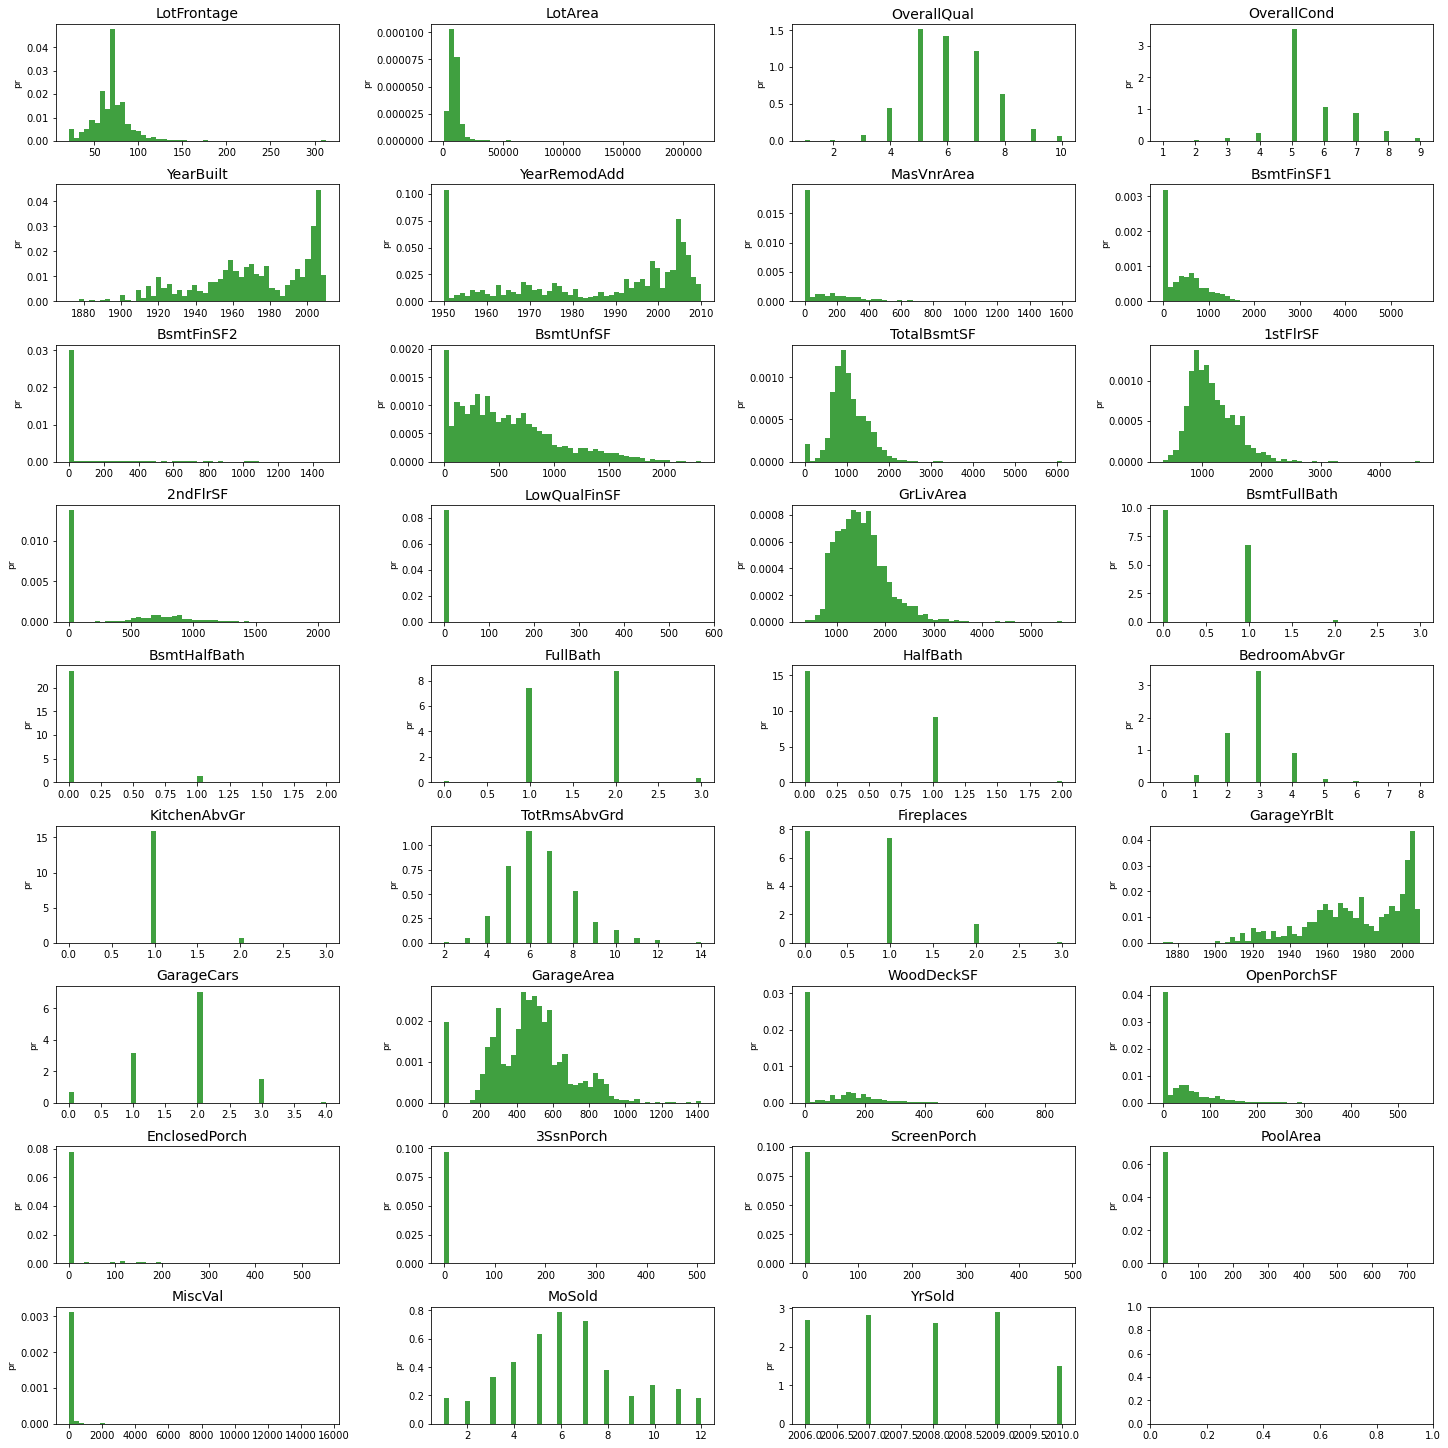

In [1090]:
fig, axs = plt.subplots(nrows=9, ncols=4, constrained_layout=True, figsize=(20, 20))
for i in range(num_columns.shape[0]):
    example_plot(axs.flat[i], df[num_columns[i]], num_columns[i], 'hist')

#### Многие признаки не имеют нормально распределения и у большинства преобладает нулевое значение признака. Большинство из них связанны с категориальными признаками, описывающими дополнительную инф. о здании. Например гараж или бассейн.
#### Скорее всего эти признаки могуть коррелировать друг с другом 

In [1155]:
emissions_col = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 
                 'BsmtFinSF1','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF','GrLivArea','GarageYrBlt',
                   'GarageArea', 'WoodDeckSF', 'OpenPorchSF']

In [1117]:
for i in emissions_col:
    df = df[df[i]<=df[i].quantile(0.98)]

In [1156]:
df.shape

(1094, 325)

### Target value

Постройте распределение целевой переменной. Распределение близко к нормальному? Если нет, то можно ли как-то это исправить?

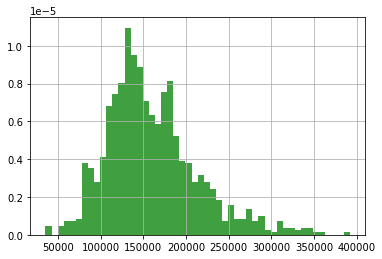

In [1118]:
import numpy as np
import matplotlib.pyplot as plt

x = df.SalePrice
mu, sigma = 100, 15
n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
plt.grid(True)
plt.show()

Вывод: 

#### Распределение недостаточно близкое к нормальному. Если убрать длинный хвост из значений в правой части, то получится привести таргет к нормальном распределению 

{'whiskers': [<matplotlib.lines.Line2D at 0x20114a30eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x20114a3e5b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20114a30b50>],
 'medians': [<matplotlib.lines.Line2D at 0x20114a3ec70>],
 'fliers': [<matplotlib.lines.Line2D at 0x20114a3ef40>],
 'means': []}

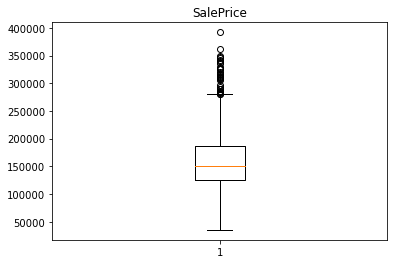

In [1119]:
fig1, ax1 = plt.subplots()
ax1.set_title('SalePrice')
ax1.boxplot(df.SalePrice)

#### Посмотрим распределение при квантили в 0,95 

{'whiskers': [<matplotlib.lines.Line2D at 0x20114af54f0>,
 'caps': [<matplotlib.lines.Line2D at 0x20114af5bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20114af5190>],
 'medians': [<matplotlib.lines.Line2D at 0x20114afd250>],
 'fliers': [<matplotlib.lines.Line2D at 0x20114afd520>],
 'means': []}

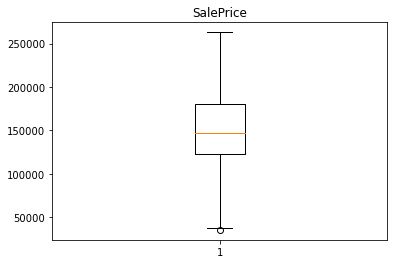

In [1120]:
fig1, ax1 = plt.subplots()
ax1.set_title('SalePrice')
ax1.boxplot(df[(df.SalePrice<=df.SalePrice.quantile(0.95))].SalePrice)

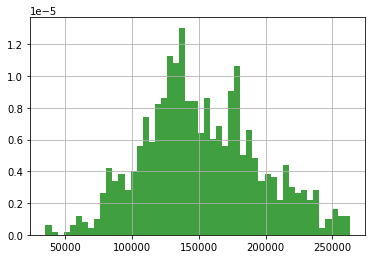

In [1121]:
x = df[(df.SalePrice<=df.SalePrice.quantile(0.95))].SalePrice
mu, sigma = 100, 15
n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)
plt.grid(True)
plt.show()

#### Теперь распределение близкое к норамальному, можно продолжать 

In [1122]:
df = df[(df.SalePrice<=df.SalePrice.quantile(0.95))]

In [1123]:
df.shape

(1094, 79)

### Categorical value preprocessing

Так как регрессионная модель не может работать с категориальными данными, их нужно закодировать при помощи OneHotEncoder или pandas.get_dummies.

In [1124]:
df_ohe = pd.get_dummies(df[obj_columns])
for col in df_ohe.columns:
    df[col] = df_ohe[col]

In [1125]:
df.shape

(1094, 325)

### Correlations

Целью корреляционного анализа является отбор признаков для дальнейшего построения модели регрессии. Постройте корреляционную матрицу.

Поиск сильной корреляции между признаками. Для регрессии нужно избавляться от одного из признаков с максимальным значением или объединить их

In [1126]:
corr = df.corr()
big_corr = []
for col in corr.columns:
    for i in corr.index:
        if i != col:
            if corr[col][i]*corr[col][i] == 1:
                big_corr.append((col, i))
# big_corr

###### Street - Бинарный признак, можно удалить одини из ('Street_Grvl', 'Street_Pave')
###### Utilities - Бинарный признак так, как в датасете встречаются только два значения из трех, можно удалить одини из ('Utilities_AllPub', 'Utilities_NoSeWa')
###### Равенстро между 'Exterior1st_CBlock', 'Exterior2nd_CBlock'  можно удалить одини из них
###### Кориляция из-за отсутствия признака BsmtQual_NA, BsmtCond_NA, BsmtFinType1_NA, нужно удалить два из трех 
###### CentralAir - бинарный признак
###### Кориляция из-за отсутствия признака GarageType_NA, GarageFinish_NA, GarageQual_NA, GarageCond_NA, нужно удалить три из четырех
###### Признаки 'GarageQual_Ex', 'GarageCond_Ex' лучше объединить так, как они описывают состояние гаража. Оставить один из них в рамках задачи можно, но на практике корреляция между качество и состоянием не всегда будет абсолютной

In [1130]:
# df['GarageQualAndCond_Ex'] = df.GarageQual_Ex+df.GarageCond_Ex
del_columns = np.array(['Street_Pave',  'Utilities_NoSeWa',  'Exterior2nd_CBlock', 'BsmtCond_NA',
                        'BsmtFinType1_NA','CentralAir_N', 'GarageFinish_NA', 'GarageQual_NA',
                        'GarageCond_NA','GarageQual_Ex', 'GarageCond_Ex'])

In [1131]:
ohe_columns = df_ohe.columns.difference(del_columns)
# ohe_columns = np.append(ohe_columns, 'GarageQualAndCond_Ex')

##### Есть много категориальный признаков с очень слабой корреляцией с таргетом. Для повышения качества модели нужно избавится от шума 

In [1132]:
corr = df[np.append(ohe_columns, 'SalePrice')].corr()
categor_big_corr_target = []
col = 'SalePrice'
for i in corr[col].index:
    if i != col:
        if abs(corr[col][i]) >= 0.1:
            categor_big_corr_target.append(i)
            
len(categor_big_corr_target)

105

In [1133]:
ohe_columns = df[categor_big_corr_target].columns.difference(del_columns)

In [1134]:
ohe_columns.shape

(105,)

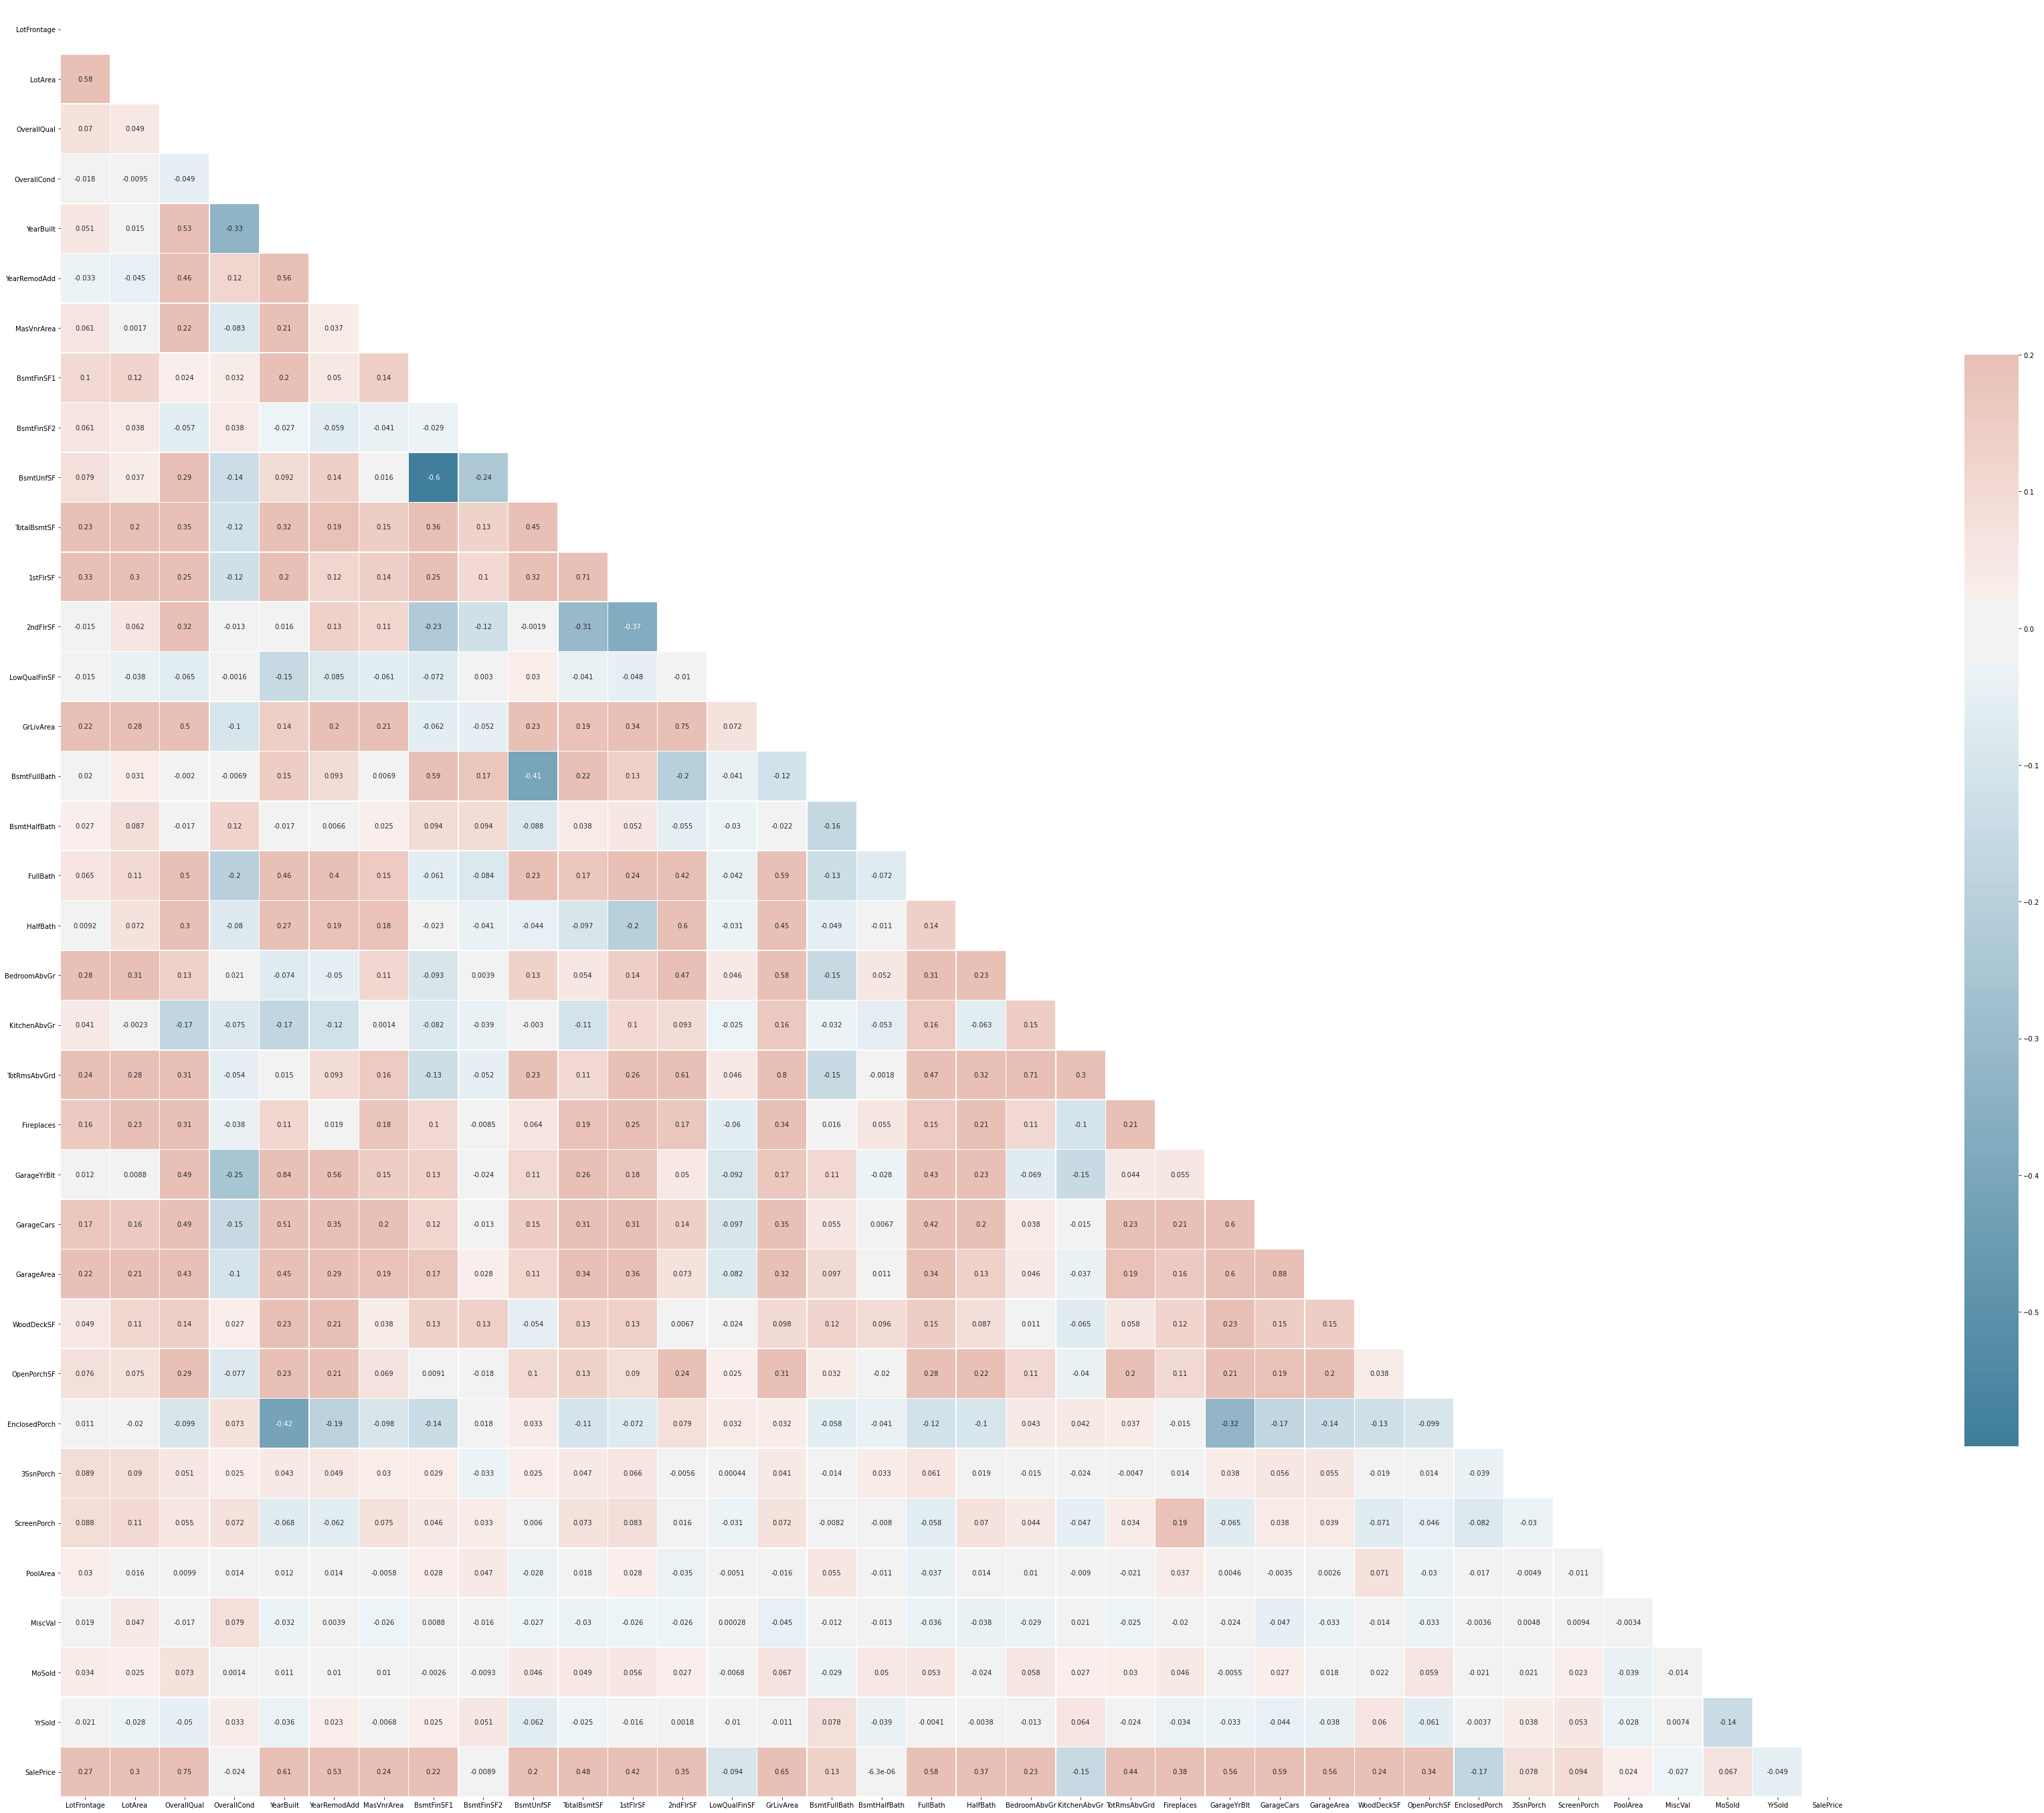

In [1135]:
from string import ascii_letters
import seaborn as sns

# Compute the correlation matrix
# corr = df[np.append(num_columns, 'SalePrice')].corr()
corr = df[np.append(num_columns, 'SalePrice')].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(60, 60))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.2, center=0, annot=True, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

fig = ax.get_figure()
# fig.savefig('corr_m.png')

##### Самые коррелирующие признаки 

In [1136]:
corr['SalePrice'].sort_values()[:5]

EnclosedPorch   -0.171378
KitchenAbvGr    -0.151710
LowQualFinSF    -0.093595
YrSold          -0.048722
MiscVal         -0.027409
Name: SalePrice, dtype: float64

In [1137]:
corr['SalePrice'].sort_values(ascending=False)[:25]

SalePrice       1.000000
OverallQual     0.747334
GrLivArea       0.646107
YearBuilt       0.605314
GarageCars      0.591865
FullBath        0.576598
GarageArea      0.564464
GarageYrBlt     0.562838
YearRemodAdd    0.525806
TotalBsmtSF     0.475489
TotRmsAbvGrd    0.437253
1stFlrSF        0.423471
Fireplaces      0.381878
HalfBath        0.368811
2ndFlrSF        0.352106
OpenPorchSF     0.343012
LotArea         0.301393
LotFrontage     0.267624
MasVnrArea      0.244398
WoodDeckSF      0.241555
BedroomAbvGr    0.231028
BsmtFinSF1      0.216834
BsmtUnfSF       0.198505
BsmtFullBath    0.127307
ScreenPorch     0.093926
Name: SalePrice, dtype: float64

Вывод: 

Среди численный признаков нет очень сильной корреляции друг с другом, поэтому можно оставить весь набор признаков 

### Numerical value preprocessing

Для улучшения сходимости алгоритма и качества модели в целом, нормализуйте числовые данные. Вы можете использовать StandartScaler или MinMaxScaler

In [1138]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df[num_columns])
df_norm = pd.DataFrame(scaler.transform(df[num_columns]), columns=num_columns)
norm_columns = df_norm.columns

In [1139]:
df_norm.shape

(1094, 35)

In [1140]:
for col in df_norm:
    df[col] = df_norm[col].values

In [1141]:
df.shape

(1094, 325)

### Feature engineering

Для улучшения качества модели следует составить новые признаки путем нелинейной обработки имеющихся. Уделите этому пункту особое внимание.

#### Агрегирование признаков

In [951]:
##### отбор корр групп 
corr_group = df[np.append(ohe_columns, norm_columns)].corr()
corr = df[np.append(ohe_columns, norm_columns)].corr()

corr_val = 0.5
for col in corr_group.columns:
    corr_group[col] = corr_group[col].apply(lambda x: 1 if abs(x)>=corr_val else 0) 
    
group = []
for col in corr_group.columns:
    if corr_group.groupby(col).count().iloc[1][0]-1 >=2:
        group.append(corr[abs(corr[col])>=corr_val].index)    

In [868]:
#### поиск максимально похожих групп
min_cross = 1

new_group = []
for group_ind_1 in group:
    for group_ind_2 in group:
        cross_group = list(set(group_ind_1) & set(group_ind_2))
        if len(group_ind_1)-len(cross_group)<=min_cross:
            count = 0
            for i in new_group:
                if i == cross_group:
                    count+=1
            if count==0:
                new_group.append(cross_group)
len(new_group)

51

In [869]:
#### Исключаем признаки находящиеся в группах из основного датасета

uni_col = []
f_e_columns = []
for i in new_group:
    for j in i:
        if not j in uni_col:
            uni_col.append(j)
len(uni_col)

for i in [ohe_columns, norm_columns]:
    for col in list(set(ohe_columns) - set(uni_col)):
        f_e_columns.append(col)

f_e_columns = list(set(f_e_columns))
len(f_e_columns)

72

In [870]:
### формирование новых признаков из групп
#### Среднее значение признаков
for group_ind in new_group:
    f_e_columns.append(str(group_ind))
    df[str(group_ind)] = df[group_ind].apply(lambda row: pd.np.mean(row), axis=1)

<ipython-input-870-8c50c3735c99>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df[str(group_ind)] = df[group_ind].apply(lambda row: pd.np.mean(row), axis=1)


In [871]:
len(f_e_columns)

123

Вывод по агрегированию:

Агрегирование не дало ожидаемого эффекта. Выделение признаков из корр групп ухудшает качество модели.

### Split train/test

Разделите данные на train и test используя метод train_test_split из библиотеки sklearn. Параметры test_size = 0.2, random_state = 10, для того у всех было одинаковое разделение.

In [1142]:
X = pd.DataFrame()

### Только числовые признаки 
# for col in norm_columns:
#     X[col] = df[col].values
    
### Только категориальные
# for col in ohe_columns:
#     X[col] = df[col].values
    
### Категориальные и числовые 
for col in norm_columns:
    X[col] = df[col].values
for col in ohe_columns:
    X[col] = df[col].values
    
### Признаки Feature engineering
# for col in f_e_columns:
#     X[col] = df[col].values

y = df.SalePrice

In [1143]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [1144]:
X_train.shape

(875, 140)

# Linear regression

После того как вы подготовили данные, можно начинать обучение модели. Для линейной регрессии используется класс LinearRegression. 

In [1147]:
from sklearn.linear_model import LinearRegression

line_reg = LinearRegression().fit(X_train, y_train)
pred = line_reg.predict(X_test)

Посчитайте среднее абсолютное отклонение на обучающей и тестовой выборке. Смотрите sklearn mean_absolute_error.

In [1146]:
print(f"Срееднее абсолютное отклонение - Train: {round(mean_absolute_error(y_train,  line_reg.predict(X_train)),2)}")
print(f"Срееднее абсолютное отклонение - Test: {round(mean_absolute_error(y_test, pred),2)}")

Срееднее абсолютное отклонение - Train: 9148.91
Срееднее абсолютное отклонение - Test: 10950.64


In [956]:
print(f"Срееднее абсолютное отклонение - Train: {round(mean_absolute_error(y_train,  line_reg.predict(X_train)),2)}")
print(f"Срееднее абсолютное отклонение - Test: {round(mean_absolute_error(y_test, pred),2)}")

Срееднее абсолютное отклонение - Train: 13768.34
Срееднее абсолютное отклонение - Test: 15594.18


Также для анализа модели можно построить график остатков.

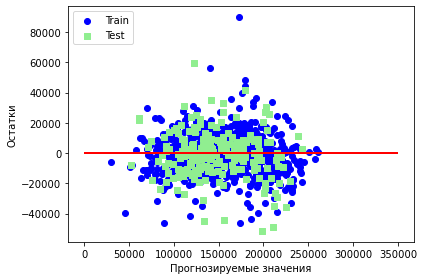

In [1148]:
y_train_pred = line_reg.predict(X_train)
y_test_pred = line_reg.predict(X_test)

plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Train')

plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test')

plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')

plt.legend(loc='upper left')

plt.hlines(y=0, xmin=-10, xmax=350000, lw=2, color='red')
plt.xlim()
plt.tight_layout()

### Regularization

Для повышения качества вы можете попробовать добавить регуляризацию в модель регрессии. Для этого используйте sklearn.linear_model Ridge, ElasticNet, Lasso.

In [1149]:
sc_y = StandardScaler()
sc_y.fit(y.values.reshape(-1, 1))
y_train_scaled = sc_y.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = sc_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [1150]:
line_reg = LinearRegression().fit(X_train, y_train_scaled)
pred = line_reg.predict(X_test)

print(f"Срееднее абсолютное отклонение - Train: {round(mean_absolute_error(y_train_scaled,  line_reg.predict(X_train)),2)}")
print(f"Срееднее абсолютное отклонение - Test: {round(mean_absolute_error(y_test_scaled, pred),2)}")

Срееднее абсолютное отклонение - Train: 0.21
Срееднее абсолютное отклонение - Test: 0.25


In [1151]:
from sklearn.model_selection import cross_val_score

In [1152]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train_scaled)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
# print(lasso.coef_)

print(f"Срееднее абсолютное отклонение Lasso - Train: {round(mean_absolute_error(y_train_scaled,  y_train_pred),2)}")
print(f"Срееднее абсолютное отклонение Lasso - Test: {round(mean_absolute_error(y_test_scaled, y_test_pred),2)}")

scores = cross_val_score(lasso, X_train, y_train_scaled, cv=5)
np.median(scores)

Срееднее абсолютное отклонение Lasso - Train: 0.22
Срееднее абсолютное отклонение Lasso - Test: 0.24


0.852029092441716

In [1153]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train_scaled)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
# print(ridge.coef_)

print(f"Срееднее абсолютное отклонение Ridge - Train: {round(mean_absolute_error(y_train_scaled,  y_train_pred),2)}")
print(f"Срееднее абсолютное отклонение Ridge - Test: {round(mean_absolute_error(y_test_scaled, y_test_pred),2)}")

scores = cross_val_score(ridge, X_train, y_train_scaled, cv=5)
np.median(scores)

Срееднее абсолютное отклонение Ridge - Train: 0.21
Срееднее абсолютное отклонение Ridge - Test: 0.25


0.8452198900530143

In [1154]:
from sklearn.linear_model import ElasticNet

en = ElasticNet(alpha=0.01, l1_ratio=0.1)
en.fit(X_train, y_train_scaled)
y_train_pred = en.predict(X_train)
y_test_pred = en.predict(X_test)
# print(en.coef_)

print(f"Срееднее абсолютное отклонение Ridge - Train: {round(mean_absolute_error(y_train_scaled,  y_train_pred),2)}")
print(f"Срееднее абсолютное отклонение Ridge - Test: {round(mean_absolute_error(y_test_scaled, y_test_pred),2)}")

scores = cross_val_score(en, X_train, y_train_scaled, cv=5)
np.median(scores)

Срееднее абсолютное отклонение Ridge - Train: 0.22
Срееднее абсолютное отклонение Ridge - Test: 0.24


0.8501126618053526

Напишите общий вывод по всей работе.Какие зависимости в данных вы нашли, как вы предобрабатывали данные и какой это дало результат, какая модель была лучше других и почему и т.д. Оценивается ход мыслей, а не математическая верность ответа.

Вывод:

##### Немного изменил изначальную последовательную решения. Старался сразу при разборе определённых признаков их пред обрабатывать.

##### План примерно следующий:

###### 1.Привести данные к числам
###### 2.Корректор заполнить нулевые значения исходя из смысла признака
###### 3.Оценить взаимосвязь между признаками 
###### 4.Обучить модель на и получившемся датасете и уже потом менять наборы признаков и условия пред обработки 


 


##### Выводы и ключевые результаты:
-В ходе анализа данных при ohe было много признаков, которые коррелировали между собой и в результате модель не получалось построить.
-Устранив их нашел признаки, которые можно было бы объединить в группы и получить латентные признаки из групп. Но все манипуляции с группированной не принесли дополнительного качества. 
-Самыми полезными для качества модели стали очистка от выбросов, добавление ohe и приведение таргита к нормальному распределению. 
-В Feature engineering не получилось выделить новых признаков из имеющихся, классические способы (объединение даты, разделение числовых признаков и т.д.) не было возможности применить на имеющихся данных. 